**Data product options:**
* Technique 1 - unique articles published
    * Every Monday morning TRAIN on unique articles published in last 7 days (On May 3, take articles pub between Apr26-May2). Purpose - to get model files
    * Every night PREDICT on articles published during day for 7 days (May3-May 9 will get topics from above model). Purpose - to get topic labels for each article
    * Caveat - We are training on articles which already have labels (through prediction). And training and prediction labels may differ
    * Verdict - complicated and prone to discrepancies
    
* Technique 1 - unique articles published (simplified)
    * 

* Technique 2 - every week train on few days
    * Every Wednesday night, TRAIN on articles read with >100 pvs. 
    * 

In [1]:
""" Helper imports"""
import re
import joblib
import pandas as pd
import numpy as np
from time import time
from nltk.tokenize import sent_tokenize
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import cosine_similarity

"""Modeling imports"""
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

""" Plotting imports"""
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# remove this later
pd.set_option('max_colwidth', 110)
import warnings
warnings.filterwarnings('ignore')

### Competitor research:
* WSJ uses HDBSCAN - https://medium.com/the-wall-street-journal/staying-on-topic-building-an-automated-topic-model-of-wsj-news-coverage-d4dc4369f71b

In [2]:
from src.util import (c_tf_idf, 
                      extract_top_n_words_per_topic,
                      extract_topic_sizes,
                      topic_cos_sim_metrics,
                      generate_all_cossim_metrics)

In [3]:
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from hdbscan import validity_index

In [4]:
data_path = '/home/jupyter/bi-topic-modeling/data/' 

STOP_WORDS = pd.read_pickle(data_path + 'forbes_stop_words.pkl')
"q1" in STOP_WORDS

True

In [5]:
results_path = '/home/jupyter/bi-topic-modeling/results/' 
SEED = 42

### --- Input data ---

* Articles read on Apr 25 with over 100 pvs

In [6]:
df = pd.read_csv(data_path + 'processed/train_apr25_over100pvs_processed.csv')

print("Shape:", df.shape)
print("Unique tiers:", len(df.tier1.unique()))

Shape: (3334, 10)
Unique tiers: 31


* Per verdict from EDA, will be excluding articles less than 100 words

In [7]:
df["article_length"] = df.clean_body.str.split().apply(len)
df = df[df["article_length"]>=100]
print("Shape", df.shape)
df.tier1 = df.tier1.fillna('Other')
df = df.reset_index(drop=True)

Shape (3327, 11)


### --- Modeling ---

**Generate embeddings**

In [28]:
data = df.clean_body.tolist()
print(len(data))

3327


In [29]:
article_embeddings = joblib.load("./data/processed/apr25_article_embed_axis0.joblib")

In [30]:
# SETTINGS - umap:n_neighbors=15, n_components=5, hdbscan min_cluster_size=5, input = sentences aggregated to full article

# dimensionality reduction
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine',
                            random_state = SEED).fit(article_embeddings) # min_dist=0.0,

In [31]:
# cluster
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                      metric= 'euclidean',                      
                      cluster_selection_method='eom',
                      prediction_data=True).fit(umap_embeddings.embedding_)

In [32]:
# 3327 articles compressed to 5 components

print("Shape of training embeddings:", umap_embeddings.embedding_.shape)

Shape of training embeddings: (3327, 5)


In [14]:
labels = cluster.labels_
print("Settings - mean axis=0")
validity_index(umap_embeddings.embedding_.astype('double'), labels)

Settings - mean axis=0


0.3250975412699008

In [34]:
# put topics in dataframe
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

print("Distinct topics including -1 for noise", len(docs_df.Topic.unique()))
print()
docs_df

Distinct topics including -1 for noise 111



,Doc,Topic,Doc_ID
0,"wayfairs biggest sale of the year is officially here. thanks to the pandemic, most of us have spent the pa...",-1,0
1,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list ...",-1,1
2,these 11 mattress toppers give you the bed of your dreams. while new pillows or a new set of sheets can do...,24,2
3,these 10 cozy down alternative comforters make your bed feel extra luxurious. your bed should be your safe...,24,3
4,"the wnba turns 25. what will viewership trends mean for the future?. twenty-five years ago, the national b...",52,4
...,...,...,...
3322,friends do not let friends become chinese billionaires. update: chinese nationals are not the only ones ge...,-1,3322
3323,how do you change an organizational culture?. changing an organizations culture is one of the most difficu...,-1,3323
3324,"three ways to keep those secret purchases secret. not everything in life is meant to be aired in public, a...",-1,3324
3325,alexander the great: gay or straight?. (one in a series of conversations between historians james romm and...,-1,3325


In [35]:
# combine together all articles belonging to same cluster  
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

# calculate countVector and tf-idf
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

# top n words, topic size
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 

# modify top_n_words per topic dict into dataframe for presentation
topic_words_dict = {}  

for k, v in top_n_words.items():
    topic_words_dict[k] = ", ".join([elem[0] for elem in v])

pd.set_option("max_colwidth", 250)
top_n_words_df = pd.DataFrame.from_dict(topic_words_dict, 
                                        orient='index').reset_index().rename(columns={'index':'topic_num',
                                                                                      
                                                                                      0:'top_20_words'}) 

In [36]:
# clean keywords

from collections import OrderedDict
# from fuzzywuzzy import process, fuzz
from itertools import chain

import time
start = time.time()

clean_keys = []
for index, row in top_n_words_df.iterrows(): 
    
    # remove STOP WORDS and remove whitespaces
    inter_list = [x.strip() for x in row["top_20_words"].split(",") if x not in STOP_WORDS]
    
    # remove numbers but not alphanumerics e.g. remove 400, not ps4 
    inter_list = [x for x in inter_list if not x.isnumeric()]
    
    # remove subset-based similar words - e.g. 'pcr tests' and 'tests' then 'tests' will be removed
    inter_list = [i for i in inter_list if not any(i in x and i!=x for x in inter_list)]
    
    # not fuzzy matching
    #     if(len(inter_list)>15):
#         # remove similar words using fuzzy match with score>85 - e.g. 'student loans' and 'student loan debt'
#         matches_to_remove = []
#         for i in range(len(inter_list)):
#             process_match = process.extract(inter_list[i], inter_list, scorer=fuzz.partial_ratio) # match every word with other word
#             filter_match = [x for x in process_match if x[1]>85 and x[1]<100] 
#             matches_to_remove.append([x[0] for x in filter_match])
#         matches_to_remove_list = list(set(list(chain(*matches_to_remove))))
#         inter_list = [x for x in inter_list if x not in matches_to_remove_list]

    # remove empty or 1-letter words
    inter_list = [x for x in inter_list if len(x)>1]
    
    # de-duplicate
    inter_list = list(OrderedDict.fromkeys(inter_list))
    
    # keep top 20 cleaned keywords
    inter_list = inter_list[:20] 
    
    # convert into strng
    inter_list = ', '.join(inter_list)
    
    clean_keys.append(inter_list)

end = time.time()
print("keyword time", (end - start)/60) 

keyword time 0.0001826047897338867


In [37]:
top_n_words_df["top_20_words"] = clean_keys

In [38]:
# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
apr25_cossim_df = generate_all_cossim_metrics(docs_df, article_embeddings)

# per topic - tier counts
tier_metric = docs_df.join(df[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info = pd.merge(pd.merge(pd.merge(top_n_words_df, 
                                        topic_sizes, how="inner", left_on="topic_num", right_on = "Topic"), 
                               apr25_cossim_df, on = "topic_num", how="inner"), 
                      iab_metric, on = "topic_num", how="inner")

topic_info.drop('Topic', axis=1, inplace=True)

### --- Input data for training ---

* All (unique) articles read on Apr 25 with over 100 pvs
* Distinct topics including -1 for noise: 111

In [39]:
topic_info.tail()

,topic_num,top_20_words,Size,cos_min,cos_mean,distinct_tier1s
106,105,"wendy, failure, leadership, xanax, patriarchy, mcintyre, quotes, haters, gonna, success, regrets, feminine, anxiety, men women, intimacy, davis, started taking",10,0.83,0.91,3
107,106,"financial services, consumer, retailers, insights, medium size, cloud, analytics, distributors, data sharing, ml, real time, experiences, operations, processes, interconnected, advanced erp, adaptability, size businesses",10,0.86,0.92,4
108,107,"vr, 5g, computing, hpc, ai, fusion, technologies, ultrascale, virtual reality, connectivity, cloud, augmented, autonomous, trends, online learning, piefer",21,0.81,0.90,5
109,108,"shoulds, sorry, sign, dialogue, speaker, person, negative thought, emails, don, berman, recipient, conversation, listening, small talk, self discipline, thoughts, lett likes",20,0.75,0.91,5
110,109,"emotions, overthinking, stress, brain, negative thoughts, psychotic, negative people, feelings, strong people, mentally strong, empathy, toxic people, positive, emotional intelligence",20,0.81,0.91,3


* Observation on cluter-goodness:
    * Good quality overall - 
        * most articles in a group on avg have 0.85-0.93 cosine similarity which is pretty high
        * min similarity is also 0.7 and above for most topics
        * most topics have 4-5 distinct tiers 
        
    * Manual eyeballing - 88 topics good, 19 bad

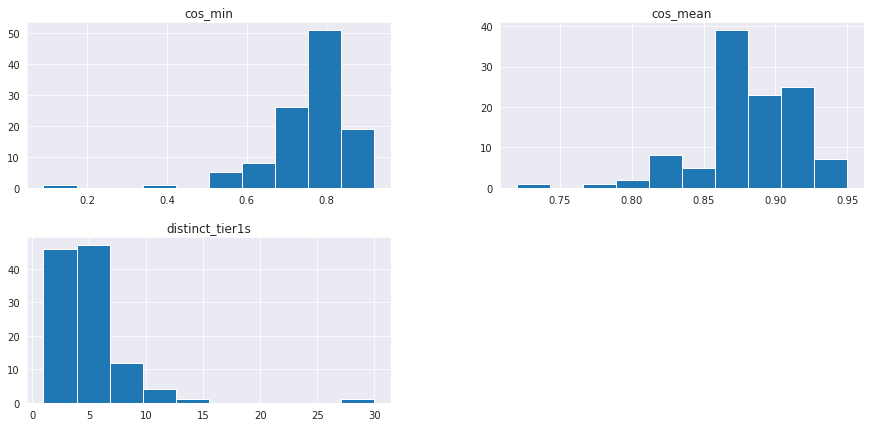

In [25]:
topic_info[['cos_min', 'cos_mean', 'distinct_tier1s']].hist(figsize= (15,7))
plt.show()

**Topics are about:**


In [32]:
topic_info.to_csv(results_path+"apr25_topics_metics_05252021.csv", index=False)
tier_metric.to_csv(results_path+"apr25_docsdf_tiers_05252021.csv", index=False)

In [26]:
joblib.dump(umap_embeddings, "umap_obj.joblib")
joblib.dump(cluster, "clusterer_obj.joblib")

['clusterer_obj.joblib']

* **Predict new points/articles - Apr 26**

In [8]:
umap_embeddings = joblib.load("umap_obj.joblib")
cluster = joblib.load("clusterer_obj.joblib")

print(umap_embeddings)
print()
print(cluster)

UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0, metric='cosine',
     n_components=5, random_state=42)

HDBSCAN(prediction_data=True)


In [9]:
# Apr 26 orig dataframe

df_apr26 = pd.read_csv("./data/processed/pred_apr26_over100pvs_processed.csv")

df_apr26["article_length"] = df_apr26.clean_body.str.split().apply(len)
df_apr26 = df_apr26[df_apr26["article_length"]>=100]

df_apr26.tier1 = df_apr26.tier1.fillna('Other')
df_apr26 = df_apr26.reset_index(drop=True)

print(df_apr26.shape)

(4128, 11)


In [10]:
article_embeddings_apr26 = joblib.load( "./data/processed/apr26_article_embed_axis0.joblib")
print("Before:", len(article_embeddings_apr26))

Before: 4128


**Note:** 
* There will be articles read on Apr 25 (training set), which will also be read the next day. 
* These common articles present in prediction set, will get the same topic cluster as before

In [14]:
# choose only non-repeating articles
df_apr26 = df_apr26[~df_apr26.content_natid.isin(df.content_natid)]
print(df_apr26.shape)

# choose embeddings for only non-repeating articles
article_embeddings_apr26 = [article_embeddings_apr26[i] for i in list(df_apr26.index)]
print("After:", len(article_embeddings_apr26))

(1218, 11)
After: 1218


In [16]:
df_apr26 = df_apr26.reset_index(drop=True)

In [17]:
# dimensionality reduction
umap_embeddings_apr26 = umap_embeddings.transform(article_embeddings_apr26) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_apr26.shape)

Training input shape: (3327, 5)
Prediction input shape: (1218, 5)


In [18]:
# predict

apr26_test_labels, apr26_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_apr26)

print(len(apr26_test_labels))
print(set(apr26_test_labels))

1218
{0, 1, 2, 3, 5, 6, 7, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 38, 39, 41, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 81, 82, 85, 87, 88, 89, 90, 91, 94, 95, 96, 97, 98, 100, 102, 103, 104, 105, 107, 108, 109, -1}


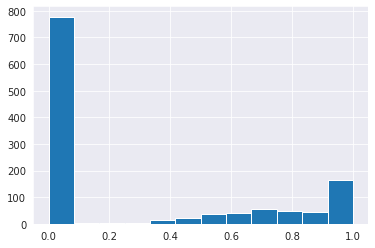

In [19]:
plt.hist(apr26_strengths, bins='auto')
plt.show()

**Note:** 21 topics were not assigned to articles read the next day

In [20]:
# put topics in dataframe
apr26_docs_df = df_apr26[['clean_body']]
apr26_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
apr26_docs_df["Topic"] = apr26_test_labels

print("Distinct topics including -1 for noise", len(apr26_docs_df.Topic.unique()))
print()
apr26_docs_df.tail()

Distinct topics including -1 for noise 90



,Doc,Topic
1213,why are manholes round? the 10 toughest interview questions. a job interview at one of google 's 75 campus...,102
1214,"security guru launches iphone app to hack colorblindness. in 2008, security researcher dan kaminsky discov...",-1
1215,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, ha...",-1
1216,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut b...,-1
1217,fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communication...,-1


In [21]:
# apr26_docs_df.isna().sum()
apr26_topic_sizes = extract_topic_sizes(apr26_docs_df)

In [22]:
# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
apr26_cossim_df = generate_all_cossim_metrics(apr26_docs_df, umap_embeddings_apr26)

# per topic - tier counts
tier_metric = apr26_docs_df.join(df_apr26[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info = pd.merge(pd.merge(apr26_topic_sizes, 
                                        apr26_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info.drop('Topic', axis=1, inplace=True)

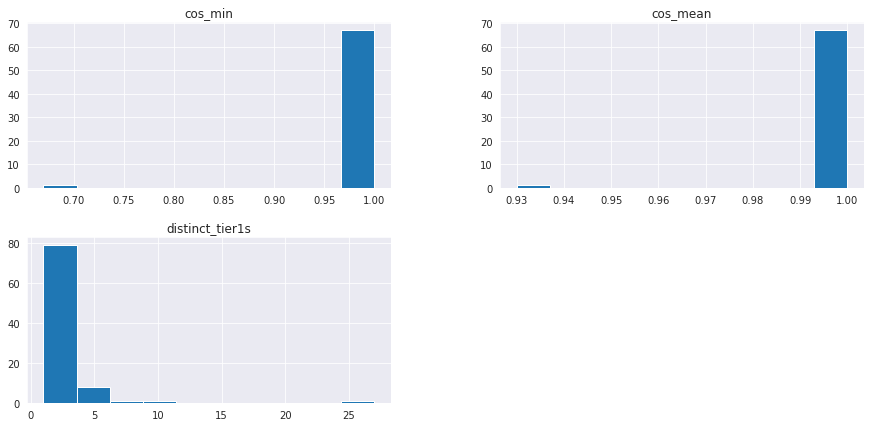

In [24]:
topic_info[['cos_min', 'cos_mean', 'distinct_tier1s']].hist(figsize= (15,7))
plt.show()

**Observation -**
* predictions are very conservative - 770 articles considered noise and just 450 articles labeled
* on avg. number of articles assigned to a predicted topic = 3. i.e. small clusters

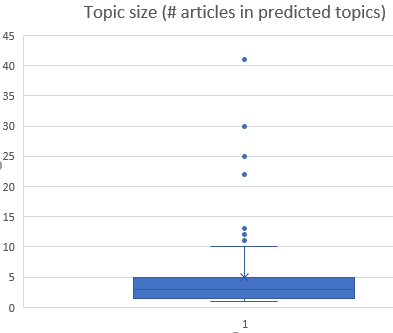

In [25]:
topic_info.sort_values('topic_num').to_csv(results_path+"apr26_nonmatch_topic_inspection.csv", index=False) #.head()

In [42]:
pred_apr26_inspect = pd.merge(apr26_docs_df, 
         top_n_words_df, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

In [45]:
pred_apr26_inspect

,Doc,Topic,top_20_words
0,"apple ios 14.5 released: massive iphone update with cool features & important fixes. april 28 update below. this post was first published on april 26. apples latest iphone software update is with us. oh, finally. its been a long time coming and i...",-1,"ai, students, customers, coffee, human, employees, amazon, brand, marketing, product, remote, industry, digital, working, community, consumers, games, businesses, experience"
1,"apple airtag: all you need to know about the game-changing new gadget. april 28 update below. this post was first published on monday, april 26. apples all-new product category, airtag, is with us in a matter of days. its a small, cute wireless t...",-1,"ai, students, customers, coffee, human, employees, amazon, brand, marketing, product, remote, industry, digital, working, community, consumers, games, businesses, experience"
2,"missing paris? visit virtually with a cooking class from la cuisine paris. missing paris? me too. like so many people, paris is my favorite city to visit. when i was in college, i studied for a year in paris and some of my favorite things to do a...",-1,"ai, students, customers, coffee, human, employees, amazon, brand, marketing, product, remote, industry, digital, working, community, consumers, games, businesses, experience"
3,"new orleans pelicans found what they needed in naji marshall. new orleans pelicans executive vice president of basketball operations david griffin needs to increase his salary cap margins, and margins for error, as much as possible before zion wi...",88,"pacers, brissett, celtics, knicks, brimah, 2k, turner, nba, indiana, bitadze, season, walker, robinson, omega, injury, myles, bjorkgren said, bates, tatum"
4,"appraisal industry seeks to improve diversity and inclusion in the profession. the coronavirus pandemic has drawn widespread attention to existing inequalities in american society, including the racial wealth gap in real estate. as a result, a pu...",-1,"ai, students, customers, coffee, human, employees, amazon, brand, marketing, product, remote, industry, digital, working, community, consumers, games, businesses, experience"
...,...,...,...
1213,why are manholes round? the 10 toughest interview questions. a job interview at one of google 's 75 campuses around the globe might seem to have more in common with pledging a secret fraternity than job-hunting. an often months-long interview pro...,102,"new job, boss, job search, manager, recruiters, interviewer, employer, hiring, tell, interview questions, candidates, career, hr, position"
1214,"security guru launches iphone app to hack colorblindness. in 2008, security researcher dan kaminsky discovered and helped develop a patch for one of the most fundamental flaws ever found in the infrastructure of the internet. lately he is been wo...",-1,"ai, students, customers, coffee, human, employees, amazon, brand, marketing, product, remote, industry, digital, working, community, consumers, games, businesses, experience"
1215,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",-1,"ai, students, customers, coffee, human, employees, amazon, brand, marketing, product, remote, industry, digital, working, community, consumers, games, businesses, experience"
1216,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,-1,"ai, students, customers, coffee, human, employees, amazon, brand, marketing, product, remote, industry, digital, working, community, consumers, games, businesses, experience"


In [46]:
pred_apr26_inspect.to_csv(results_path+"apr26pred_nonmatch_inspection.csv", index=False)

* **Apr 26 - individual day topic modeling**

In [49]:
df_apr26 = pd.read_csv(data_path + 'processed/pred_apr26_over100pvs_processed.csv')
df_apr26["article_length"] = df_apr26.clean_body.str.split().apply(len)
df_apr26 = df_apr26[df_apr26["article_length"]>=100]
print("Shape", df_apr26.shape)
df_apr26 = df_apr26.reset_index(drop=True)

df_apr26.tier1 = df_apr26.tier1.fillna('Other')

data_apr26 = df_apr26.clean_body.tolist()
print(len(data_apr26))

Shape (4128, 11)
4128


In [47]:
# cluster
cluster_apr26 = hdbscan.HDBSCAN(min_cluster_size=5,
                      metric='euclidean',                      
                      cluster_selection_method='eom',
                      prediction_data=True).fit(umap_embeddings_apr26)

In [48]:
labels = cluster_apr26.labels_
print("Settings - mean axis=0")
validity_index(umap_embeddings_apr26.astype('double'), labels)

Settings - mean axis=0


0.29489139288874827

In [50]:
# put topics in dataframe
docs_df_apr26 = pd.DataFrame(data_apr26, columns=["Doc"])
docs_df_apr26['Topic'] = cluster_apr26.labels_
docs_df_apr26['Doc_ID'] = range(len(docs_df_apr26))

print("Distinct topics including -1 for noise", len(docs_df_apr26.Topic.unique()))
print()
docs_df_apr26

Distinct topics including -1 for noise 132



,Doc,Topic,Doc_ID
0,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list of favorite chores. you can avoid cleaning, or enlist the aid of a robot vacuum to clean your home autonomously. the best robot vacuums are ...",-1,0
1,"these 11 mattress toppers give you the bed of your dreams. while new pillows or a new set of sheets can do a lot to improve how you sleep at night, those small changes arent always enough if there are bigger issues at play, like bad alignment or ...",27,1
2,"wayfairs biggest sale of the year is officially here. thanks to the pandemic, most of us have spent the past year at home, forced to stare at the same worn-in couch, threadbare arm chair and sparse wall art. so if youre feeling like its time for ...",-1,2
3,"apple ios 14.5 released: massive iphone update with cool features & important fixes. april 28 update below. this post was first published on april 26. apples latest iphone software update is with us. oh, finally. its been a long time coming and i...",21,3
4,"apple airtag: all you need to know about the game-changing new gadget. april 28 update below. this post was first published on monday, april 26. apples all-new product category, airtag, is with us in a matter of days. its a small, cute wireless t...",21,4
...,...,...,...
4123,"security guru launches iphone app to hack colorblindness. in 2008, security researcher dan kaminsky discovered and helped develop a patch for one of the most fundamental flaws ever found in the infrastructure of the internet. lately he is been wo...",21,4123
4124,"mark zuckerberg joins the north american man-boy love association, and other adventures in facebook groups. my colleague kashmir hill congratulated facebook's mark zuckerberg earlier today on his increasingly savvy approach to talking about priva...",52,4124
4125,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",-1,4125
4126,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,-1,4126


In [54]:
# combine together all articles belonging to same cluster  
docs_per_topic_apr26 = docs_df_apr26.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

# calculate countVector and tf-idf
tf_idf_apr26, count_apr26 = c_tf_idf(docs_per_topic_apr26.Doc.values, m=len(data_apr26))

# top n words, topic size
top_n_words_apr26 = extract_top_n_words_per_topic(tf_idf_apr26, count_apr26, docs_per_topic_apr26, n=20)
topic_sizes_apr26 = extract_topic_sizes(docs_df_apr26)

# modify top_n_words per topic dict into dataframe for presentation
topic_words_dict_apr26 = {}  

for k, v in top_n_words_apr26.items():
    topic_words_dict_apr26[k] = ", ".join([elem[0] for elem in v])

pd.set_option("max_colwidth", 250)
top_n_words_df_apr26 = pd.DataFrame.from_dict(topic_words_dict_apr26, 
                                        orient='index').reset_index().rename(columns={'index':'topic_num',
                                                                                      
                                                                                      0:'top_20_words'}) 

In [55]:
top_n_words_df_apr26

,topic_num,top_20_words
0,-1,"leaders, amazon, trust, human, success, care, self, age, culture, management, percent, news, customer, businesses, assets, industry, sales, doing, government, skills"
1,0,"moon, supermoon, moons, eclipse, lunar, pink moon, supermoons, super, super pink, sky, blood moon, perigee, pink, blue moon, orbit, sun, earth, lunar eclipse, moonrise, skies"
2,1,"mars, flat earth, spacex, nasa, space program, astronauts, starlink, antarctica, flat, rocket, earth, satellites, stuhlinger, space, satellite, photon, spacecraft, rocket lab, mission, beck"
3,2,"superman, pais, dr pais, pigments, nasa, oxygen, astronauts, mars, krypton, photons, moxie, man steel, planet, salotti, cosmonaut, fusion, technosignatures, astronaut, superman black, extraterrestrial"
4,3,"earth, sun, solar, orbit, galaxies, planets, mars, atmosphere, planet, gravitational, moon, helium, mass, km, black hole, surface, satellites, million years, crust, black holes"
...,...,...
127,126,"leaders, successful leaders, ulrich, skills, soft skills, leadership, leader, successful, inspirational, team members, bridging, listening, inspirational leaders, engagement, assessment, organizational, organization, duncan, remote, happiness"
128,127,"culture, hr, diverse, positive culture, corporate culture, positive, company culture, diversity, workplace, workforce, positive company, talent, diverse workforce, positive corporate, positive workplace, sweetgreen, corporate, employees, employee..."
129,128,"lett, leadership, real meaning, sign, patriarchy, vulnerability, email, perfectionism, men, unlearn, translation, emails, discipline, lett likes, haters, recipient, peggy, self discipline, regards, don"
130,129,"overthinking, thoughts, psychotic, negative, emotions, strong people, feelings, empathy, discomfort, mentally strong, psychosis, pity, thinking, negative thoughts, negative reviews, mentally, self pity, personality, procrastination, uncomfortable"


* **Predict new points - Apr 27**

In [ ]:
article_embeddings_apr27 = joblib.load( "./data/processed/apr27_article_embed_axis0.joblib")
umap_embeddings_apr27 = umap_embeddings.transform(article_embeddings_apr27) # min_dist=0.0, #4.57

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_apr27.shape)

apr27_test_labels, apr27_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_apr27)
print(set(apr27_test_labels))